# Lung Cancer Segmentation using nnU-Net
Author: Tang Yu Xuan <br />
Institution: Multimedia University<br /><br />
## Table of Contents

1. Environment Setup
2. Data Analysis
3. Preprocessing
4. Training
5. Evaluation
6. Visualization
7. Clinical Validation
8. Results Export

# 1. Environment Setup

In [2]:
!whoami

doodledaron


## Install required packages

In [2]:
# Import basic packages
!pip install nnunetv2
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 

In [1]:
# Check if nnunet can be imported
import nnunetv2

ModuleNotFoundError: No module named 'nnunetv2'

## 1.1 Import Required Packages

In [1]:
# Basic packages
import os
import shutil
import datetime
from collections import OrderedDict
import json
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import logging
from pathlib import Path
from typing import List, Tuple, Dict

# For visualization
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from skimage.measure import marching_cubes  # For 3D visualization

# For evaluation metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
from medpy.metric.binary import hd95

# Experiment tracking
import wandb

## 1.2 Setup logging

In [4]:
import logging
from datetime import datetime
import os
import sys
from typing import Optional

class Logger:
    """Centralized logging configuration for the project"""
    
    def __init__(self, log_dir: str, name: str = "lung_segmentation"):
        self.log_dir = log_dir
        self.name = name
        self._initialize_logging()

    def _initialize_logging(self):
        """Initialize logging configuration"""
        # Create logs directory if it doesn't exist
        os.makedirs(self.log_dir, exist_ok=True)

        # Create timestamped log file
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        log_file = os.path.join(self.log_dir, f"{self.name}_{timestamp}.log")

        # Configure logging format
        formatter = logging.Formatter(
            '%(asctime)s - %(name)s - %(levelname)s - %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S'
        )

        # File handler
        file_handler = logging.FileHandler(log_file)
        file_handler.setFormatter(formatter)

        # Console handler
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(formatter)

        # Configure root logger
        logger = logging.getLogger()
        logger.setLevel(logging.INFO)
        logger.addHandler(file_handler)
        logger.addHandler(console_handler)

        # Log initial message
        logging.info(f"Logging initialized. Log file: {log_file}")

    @staticmethod
    def get_logger(name: Optional[str] = None) -> logging.Logger:
        """Get logger instance"""
        return logging.getLogger(name)

## 1.3 GPU Check

In [5]:
def check_gpu():
    """Verify GPU availability and print device information"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    else:
        device = torch.device("cpu")
        print("No GPU available, using CPU")
    return device

# this is the code from original workshop, just in case the check_gpu() is not working
# check whether GPU accelerated computing is available
# if there is an error here, enable GPU in the Runtime
# assert torch.cuda.is_available()

device = check_gpu()

Using GPU: NVIDIA GeForce RTX 4060 Ti
GPU Memory: 17.18 GB


## 1.4 Initialize Weights & Biases - External library to track GPU Performance


In [2]:
def init_wandb(project_name: str = "FYP - nnU-Net"):
    """Initialize Weights & Biases tracking"""
    wandb.init(project=project_name)
    print("Initialized Weights & Biases tracking")

init_wandb()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/doodledaron/.netrc


Initialized Weights & Biases tracking


## 1.6 Connect to Google Drive and Set Environment

In [15]:
class EnvironmentSetup:
    def __init__(self, base_path: str = "home\doodledaron\FYP\nnUnet"):
        # Initialize logging
        self.logger = Logger(
            log_dir=os.path.join(base_path, "logs"),
            name="environment_setup"
        ).get_logger(__name__)

        self.base_path = base_path
        self.setup_paths()

    def setup_paths(self):
        """Setup nnU-Net environment paths with logging"""
        self.logger.info("Setting up nnU-Net environment paths...")
        
        try:
            paths = {
                "nnUNet_raw": os.path.join(self.base_path, "nnUNet_raw"),
                "nnUNet_preprocessed": os.path.join(self.base_path, "nnUNet_preprocessed"),
                "nnUNet_results": os.path.join(self.base_path, "nnUNet_results"),
                # "RESULTS_FOLDER": os.path.join(self.base_path, "nnUNet_results"),
                "RAW_DATA_PATH": os.path.join(self.base_path, "RawData")
            }

            # Create directories
            for key, path in paths.items():
                os.makedirs(path, exist_ok=True)
                self.logger.debug(f"Created directory: {path}")

            # Set environment variables
            for key, path in paths.items():
                os.environ[key] = path
                self.logger.info(f"Set {key} to {path}")

            self.logger.info("Environment setup completed successfully")
            
        except Exception as e:
            self.logger.error(f"Environment setup failed: {str(e)}")
            raise
env = EnvironmentSetup()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Set nnUNet_raw to /content/drive/MyDrive/FYP/nnUNet_raw
Set nnUNet_preprocessed to /content/drive/MyDrive/FYP/nnUNet_preprocessed
Set nnUNet_results to /content/drive/MyDrive/FYP/nnUNet_results
Set RAW_DATA_PATH to /content/drive/MyDrive/FYP/RawData
nnUNet_raw: /content/drive/MyDrive/FYP/nnUNet_raw
nnUNet_preprocessed: /content/drive/MyDrive/FYP/nnUNet_preprocessed
nnUNet_results: /content/drive/MyDrive/FYP/nnUNet_results
RAW_DATA_PATH: /content/drive/MyDrive/FYP/RawData


In [16]:
class ErrorHandler:
    @staticmethod
    def check_gpu_memory():
        """Check available GPU memory"""
        if torch.cuda.is_available():
            memory = torch.cuda.get_device_properties(0).total_memory
            memory_allocated = torch.cuda.memory_allocated(0)
            memory_free = memory - memory_allocated
            print(f"GPU Memory: Total={memory/1e9:.2f}GB, "
                  f"Free={memory_free/1e9:.2f}GB")
            return memory_free
        return 0

    @staticmethod
    def handle_training_error(error: Exception, checkpoint_path: str):
        """Handle training interruption"""
        print(f"Training interrupted: {str(error)}")
        if os.path.exists(checkpoint_path):
            print(f"Latest checkpoint saved at: {checkpoint_path}")
        raise error

# Create instance
error_handler = ErrorHandler()

# Initialize Training Checker

In [19]:
class TrainingTracker:
    def __init__(self, dataset_id: int = 1):
        """Initialize training tracker"""
        self.dataset_id = dataset_id
        self.results_path = os.path.join(os.environ["nnUNet_results"],
                                       f"Dataset{self.dataset_id:03d}_Lung")
        self.excel_path = os.path.join(self.results_path, "training_results.xlsx")

        # Create DataFrame to store results
        self.columns = [
            'date', 'configuration', 'fold', 'epochs',
            'train_loss', 'val_loss', 'dice_score', 'hd95',
            'training_time', 'gpu_memory_used', 'notes'
        ]
        self.results_df = pd.DataFrame(columns=self.columns)

        # Load existing results if file exists
        if os.path.exists(self.excel_path):
            try:
                self.results_df = pd.read_excel(self.excel_path)
                print("Loaded existing training results")
            except Exception as e:
                print(f"Error loading existing results: {str(e)}")

    def add_result(self, config: str, fold: int, metrics: Dict, notes: str = ""):
        """Add a training result"""
        try:
            # Get training time from log file
            log_path = os.path.join(self.results_path,
                                  f"nnUNetTrainer__{config}/{fold}/progress.txt")
            training_time = self._parse_training_time(log_path)

            # Get GPU memory usage
            gpu_memory = torch.cuda.max_memory_allocated() / 1e9 if torch.cuda.is_available() else 0

            # Create new result row
            new_result = {
                'date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'configuration': config,
                'fold': fold,
                'epochs': self._get_epochs(config, fold),
                'train_loss': metrics.get('train_loss', float('nan')),
                'val_loss': metrics.get('val_loss', float('nan')),
                'dice_score': metrics.get('dice', float('nan')),
                'hd95': metrics.get('hd95', float('nan')),
                'training_time': training_time,
                'gpu_memory_used': f"{gpu_memory:.2f} GB",
                'notes': notes
            }

            # Add to DataFrame
            self.results_df = pd.concat([self.results_df,
                                       pd.DataFrame([new_result])],
                                      ignore_index=True)

            # Save to Excel
            self.save_results()
            print(f"Added results for {config} fold {fold}")

        except Exception as e:
            print(f"Error adding result: {str(e)}")

    def save_results(self):
        """Save results to Excel file"""
        try:
            # Create summary sheet with aggregated metrics
            with pd.ExcelWriter(self.excel_path, engine='xlsxwriter') as writer:
                # Save detailed results
                self.results_df.to_excel(writer, sheet_name='Detailed Results', index=False)

                # Create summary by configuration
                summary = self.results_df.groupby('configuration').agg({
                    'dice_score': ['mean', 'std', 'min', 'max'],
                    'hd95': ['mean', 'std', 'min', 'max'],
                    'training_time': 'mean'
                }).round(4)
                summary.to_excel(writer, sheet_name='Summary by Configuration')

                # Add formatting
                workbook = writer.book
                header_format = workbook.add_format({'bold': True, 'bg_color': '#D9D9D9'})

                for sheet in writer.sheets.values():
                    for col, width in enumerate(self.get_column_widths(sheet)):
                        sheet.set_column(col, col, width)
                    sheet.set_row(0, None, header_format)

            print(f"Results saved to {self.excel_path}")

        except Exception as e:
            print(f"Error saving results: {str(e)}")

    @staticmethod
    def _parse_training_time(log_path: str) -> str:
        """Parse training time from progress.txt"""
        if not os.path.exists(log_path):
            return "N/A"

        try:
            with open(log_path, 'r') as f:
                lines = f.readlines()
                for line in reversed(lines):
                    if "training done" in line.lower():
                        # Extract time from line
                        time_str = line.split("training done,")[1].strip()
                        return time_str
        except Exception:
            pass
        return "N/A"

    @staticmethod
    def _get_epochs(config: str, fold: int) -> int:
        """Get number of epochs trained"""
        try:
            checkpoint = torch.load(f"nnUNetTrainer__{config}/{fold}/checkpoint_final.pth")
            return checkpoint.get('epoch', 0)
        except:
            return 0

    @staticmethod
    def get_column_widths(sheet) -> List[int]:
        """Get appropriate column widths based on content"""
        return [max([len(str(cell)) for cell in column]) + 2
                for column in zip(*sheet)]

# # Example usage:
# tracker = TrainingTracker()

# # After training a configuration:
# metrics = {
#     'train_loss': 0.245,
#     'val_loss': 0.189,
#     'dice': 0.934,
#     'hd95': 4.56
# }
# tracker.add_result('3d_fullres', 0, metrics, notes="Initial training run")

# 2.Data Analysis

## 2.1 Dataset Statistics

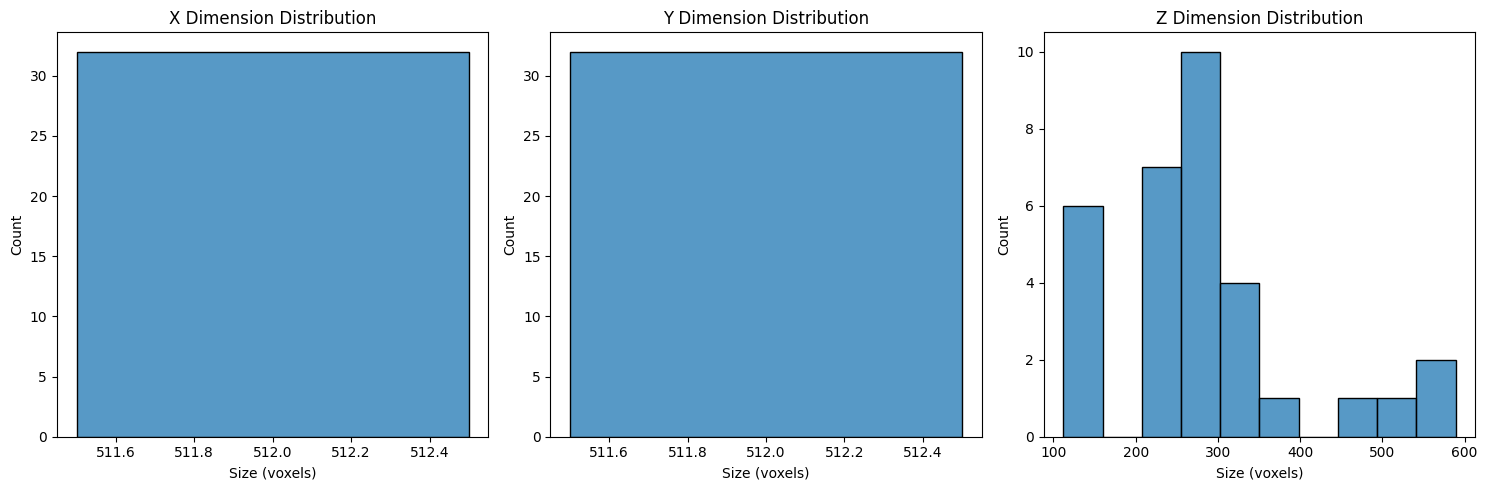

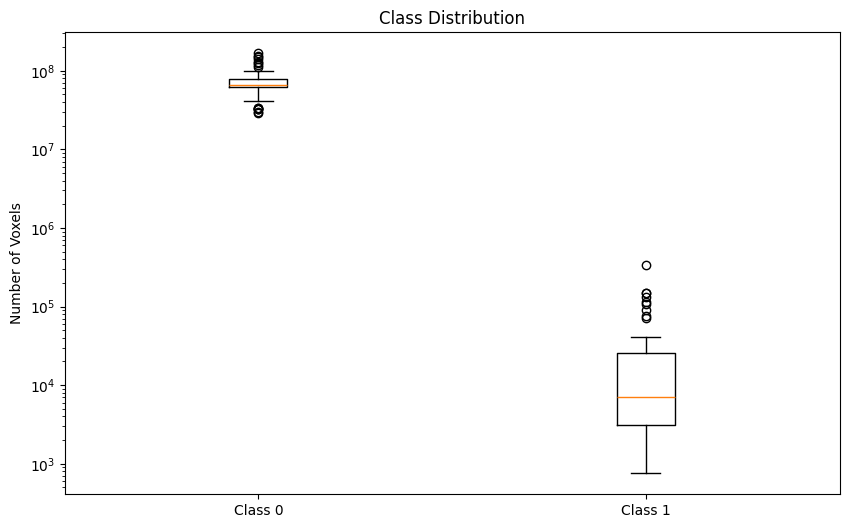

In [ ]:
#analyze Raw Dataset (Task001) in RawData, havent preprocess
class DatasetAnalyzer:
    def __init__(self, dataset_id: int = 1):
        self.dataset_id = dataset_id
        self.logger = Logger(
            log_dir=os.path.join(os.environ["nnUNet_results"], "logs"),
            name="dataset_analyzer"
        ).get_logger(__name__)        
        self.dataset_path = os.path.join(os.environ["RawData"], f"Task001_Lung")

    def load_dataset_json(self) -> dict:
        """Load and return dataset.json"""
        json_path = os.path.join(self.dataset_path, "dataset.json")
        with open(json_path, 'r') as f:
            return json.load(f)

    def get_dataset_stats(self) -> Dict:
        """Calculate basic dataset statistics"""
        stats = {
            "num_training": 0,
            "image_sizes": [],
            "spacings": []
        }

        images_path = os.path.join(self.dataset_path, "imagesTr")
        for file in os.listdir(images_path):
            if file.endswith("_0000.nii.gz"):  # First channel
                img = nib.load(os.path.join(images_path, file))
                stats["num_training"] += 1
                stats["image_sizes"].append(img.shape)
                stats["spacings"].append(img.header.get_zooms())
        print(f"Number of training images: {stats['num_training']}")
        print(f"Image sizes: {stats['image_sizes']}")
        print(f"Spacings: {stats['spacings']}")
        return stats

    def plot_size_distribution(self):
        """Plot distribution of image sizes"""
        stats = self.get_dataset_stats()
        sizes = np.array(stats["image_sizes"])

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i, dim in enumerate(['X', 'Y', 'Z']):
            sns.histplot(sizes[:, i], ax=axes[i])
            axes[i].set_title(f'{dim} Dimension Distribution')
            axes[i].set_xlabel('Size (voxels)')
        plt.tight_layout()
        plt.show()

    def analyze_class_distribution(self):
        """Analyze distribution of segmentation classes"""
        labels_path = os.path.join(self.dataset_path, "labelsTr")
        class_pixels = {}

        for file in os.listdir(labels_path):
            if file.endswith(".nii.gz"):
                img = nib.load(os.path.join(labels_path, file))
                data = img.get_fdata()
                unique, counts = np.unique(data, return_counts=True)

                for u, c in zip(unique, counts):
                    if u not in class_pixels:
                        class_pixels[u] = []
                    class_pixels[u].append(c)

        # Plot class distribution
        plt.figure(figsize=(10, 6))
        boxplot_data = [np.array(pixels) for pixels in class_pixels.values()]
        plt.boxplot(boxplot_data, labels=[f"Class {int(k)}" for k in class_pixels.keys()])
        plt.title("Class Distribution")
        plt.ylabel("Number of Voxels")
        plt.yscale('log')
        plt.show()

    def validate_dataset_format(self):
        """Validate dataset format compliance"""
        required_folders = ['imagesTr', 'labelsTr']
        required_files = ['dataset.json']

        # Check folders
        for folder in required_folders:
            folder_path = os.path.join(self.dataset_path, folder)
            if not os.path.exists(folder_path):
                raise FileNotFoundError(f"Missing required folder: {folder}")

        # Check files
        for file in required_files:
            file_path = os.path.join(self.dataset_path, file)
            if not os.path.exists(file_path):
                raise FileNotFoundError(f"Missing required file: {file}")

        print("Dataset format validation completed successfully")

    def visualize_sample_cases(self, num_samples: int = 3):
        """Visualize sample slices from the dataset"""
        images_path = os.path.join(self.dataset_path, "imagesTr")
        labels_path = os.path.join(self.dataset_path, "labelsTr")

        # Get list of image files
        image_files = [f for f in os.listdir(images_path) if f.endswith('_0000.nii.gz')]
        samples = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

        for image_file in samples:
            # Load image and corresponding label
            image = nib.load(os.path.join(images_path, image_file)).get_fdata()
            label = nib.load(os.path.join(labels_path, image_file.replace('_0000', ''))).get_fdata()

            # Get middle slice
            slice_idx = image.shape[0] // 2

            # Plot
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            ax1.imshow(image[slice_idx], cmap='gray')
            ax1.set_title('Image')
            ax2.imshow(image[slice_idx], cmap='gray')
            ax2.imshow(label[slice_idx], alpha=0.3, cmap='red')
            ax2.set_title('Label Overlay')
            plt.suptitle(f'Sample Case: {image_file}')
            plt.show()

analyzer = DatasetAnalyzer()
analyzer.plot_size_distribution()
analyzer.analyze_class_distribution()


#All images have the same size of 512 voxels (pixels) in both X and Y dimensions
#Z dimension shows more variation: ranging from ~100 to 600 voxels


#Class 0 (Background):Around 10⁸ voxels (100 million) - Very consistent across images (small box plot range)
#Class 1 (Lung lesions/cancer): Around 10³-10⁴ voxels (1,000-10,000) - More variation between images (larger box plot range)

# 3.Preprocessing


## 3.1 Run nnUnet Preprocessing
The Decathlon datasets are 4D nifti files, for nnU-Net they have to be **converted to 3D nifti** files.

For more information about dataset conversion see: [nnU-Net Dataset Formatting Instructions](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/dataset_format.md)

In [21]:
assert os.path.exists(os.path.join(os.environ["RAW_DATA_PATH"], "Task001_Lung"))

In [ ]:
def run_preprocessing(dataset_id: int = 1):
    """Run nnU-Net preprocessing"""
    # Initialize logger
    logger = Logger(
        log_dir=os.path.join(os.environ["nnUNet_results"], "logs"),
        name="preprocessing"
    ).get_logger(__name__)
    
    logger.info("Starting preprocessing...")

    # Print raw data path for verification 
    raw_path = os.path.join(os.environ["RAW_DATA_PATH"], "Task001_Lung")
    logger.info(f"Raw data path: {raw_path}")

    try:
        # Check GPU memory before starting
        if torch.cuda.is_available():
            available_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
            free_memory = available_memory - (torch.cuda.memory_allocated(0) / 1e9)
            logger.info(f"Available GPU memory: {free_memory:.2f} GB")
            
            if free_memory < 2:  # Less than 2GB free
                logger.warning("Low GPU memory available")
        #add convert dataset if needed


        # Run preprocessing
        preprocess_command = f'nnUNetv2_plan_and_preprocess -d {dataset_id} -np 2 --verify_dataset_integrity'
        logger.info(f"Running preprocessing command: {preprocess_command}")
        result = os.system(preprocess_command)
        if result != 0:
            raise RuntimeError(f"Preprocessing failed with exit code {result}")
        logger.info("Preprocessing completed successfully")

        # Verify files were created
        preprocessed_path = os.path.join(
            os.environ["nnUNet_preprocessed"],
            f"Dataset{dataset_id:03d}_Lung"
        )
        logger.info(f"Checking preprocessed path: {preprocessed_path}")

        required_files = ["dataset.json", "dataset_fingerprint.json", "nnUNetPlans.json"]
        missing_files = []
        for file in required_files:
            file_path = os.path.join(preprocessed_path, file)
            if os.path.exists(file_path):
                logger.info(f"Found required file: {file}")
            else:
                logger.warning(f"Missing required file: {file}")
                missing_files.append(file)

        if missing_files:
            raise FileNotFoundError(f"Missing required files: {', '.join(missing_files)}")

        logger.info("All required files found")
        logger.info("Preprocessing pipeline completed successfully")

    except Exception as e:
        logger.error(f"Error during preprocessing: {str(e)}")
        raise

# Call the function
run_preprocessing()

## Verify Preprocessing

In [ ]:
def verify_preprocessing(dataset_id: int = 1):
    """Verify preprocessing results"""
    preprocessed_path = os.path.join(
        os.environ["nnUNet_raw"],
        f"Dataset{dataset_id:03d}_Lung"  # This is correct for preprocessed folder
    )

    # Check existence of essential files
    required_files = ["dataset.json", "dataset_fingerprint.json", "nnUNetPlans.json"]
    for file in required_files:
        path = os.path.join(preprocessed_path, file)
        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing required file: {path}")


verify_preprocessing()

# 4. Training

## Game plan:
1. Train 3d_fullres for 1000 epochs (default) with 3 folds (less fold to save time) -> without npz flag
note: first round is to testing round to see how it works

next:
## Standard Configurations
- we add --npz flag so nnUnet can 
  - find the best configuration
  - finding the best model ensemble -> 
  1. Test individual models (2d, 3d_fullres)
  2. Test combinations/ensembles of these models (2d + 3d_fullres together)
  3. Choose what works best - either a single model OR an ensemble of multiple models

FOLD -> can be left empty, nnUnet trains with 5-fold cross-validation in default
1 -> dataset id
- nnUNetv2_train 1 2d FOLD -tr nnUNetTrainer_100epochs --npz
- nnUNetv2_train 1 3d_fullres FOLD -tr nnUNetTrainer_100epochs --npz 
- nnUNetv2_train 1 3d_lowres FOLD nnUNetTrainer_100epochs --npz
- nnUNetv2_train 1 3d_cascade_fullres FOLD nnUNetTrainer_100epochs --npz

## ResEnc M Configuration
- nnUNetv2_plan_experiment -d DATASET_ID -pl nnUNetPlannerResEncM
- nnUNetv2_train DATASET_ID 3d_fullres 0,1,2,3,4 -p nnUNetResEncUNetMPlans -num_epochs 250 --npz

## Find Best Configuration
- nnUNetv2_find_best_configuration DATASET_ID -c 2d 3d_fullres 3d_lowres 3d_cascade_fullres 3d_fullres_resenc

# Full Training (1000 epochs + 5 folds)
- Train best performing model configuration with default settings


In [ ]:
class TrainingConfig:
    def __init__(self, dataset_id: int = 1, epoch: int = 1000):
        self.dataset_id = dataset_id
        self.epoch = epoch
        self.configurations = ['2d', '3d_fullres', '3d_lowres', '3d_cascade_fullres']
        self.folds = [0, 1, 2, 3, 4]
        self.checkpoint_path = os.path.join(os.environ["nnUNet_results"],
                                          f"Dataset{dataset_id:03d}_Lung/checkpoints")
        os.makedirs(self.checkpoint_path, exist_ok=True)

    def train_quick_evaluation(self, config: str, fold: int = 0):
        """Quick training for initial evaluation (1 epoch)"""
        try:
            command = f'nnUNetv2_train {self.dataset_id} {config} {fold} -tr nnUNetTrainer_1epoch'
            print(f"Starting quick evaluation training: {command}")
            os.system(command)
            print(f"Quick evaluation training completed for {config} fold {fold}")
            
            

        except Exception as e:
            print(f"Quick evaluation failed: {str(e)}")
            raise

    #first gameplan
    def train_standard_unet(self, config: str, epoch):
        """Train with standard U-Net configuration for all 5 folds"""
        num_folds = 3 #testing purpose, train with 3 folds instead of 5, 500 epochs instead of 1000
        for fold in range(num_folds):
            try:
                # to continue training after paused (Ctrl C) addd  --continue_training flag at the end of command
                command = f'nnUNetv2_train {self.dataset_id} {config} {fold}'
                print(f"Starting standard U-Net training: {command}")
                os.system(command)
                print(f"Standard U-Net training completed for {config} fold {fold} -epoch {epoch}")
            except Exception as e:
                print(f"Standard U-Net training failed for fold {fold}: {str(e)}")
                raise
        print(f"Standard U-Net training completed for all {num_folds} folds of {config}")

    def train_residual_encoder(self, config: str, fold: int = 0):
        """Train with Residual Encoder U-Net configuration"""
        try:
            # Plan with ResEnc configuration
            os.system(f'nnUNetv2_plan_experiment -d {self.dataset_id} -pl nnUNetPlannerResEncM')

            # Train with ResEnc configuration
            command = f'nnUNetv2_train {self.dataset_id} {config} {fold} -p nnUNetResEncUNetMPlans'
            print(f"Starting ResEnc training: {command}")
            os.system(command)
            print(f"ResEnc training completed for {config} fold {fold}")

        except Exception as e:
            print(f"ResEnc training failed: {str(e)}")
            raise

    def compare_model_training(self, fold: int = 0):
        """Run different model trainings for comparison"""
        print("Starting model training comparison...")

        try:
            # 1. Quick evaluation of standard 3D U-Net
            print("Training standard 3D U-Net...")
            self.train_quick_evaluation('3d_fullres', fold)

            # 2. Quick evaluation of 2D U-Net
            print("Training 2D U-Net...")
            self.train_quick_evaluation('2d', fold)

            # 3. Quick evaluation of ResEnc
            print("Training ResEnc U-Net...")
            os.system(f'nnUNetv2_plan_experiment -d {self.dataset_id} -pl nnUNetPlannerResEncM')
            command = f'nnUNetv2_train {self.dataset_id} 3d_fullres {fold} -tr nnUNetTrainer_1epoch -p nnUNetResEncUNetMPlans'
            os.system(command)

            print("All model trainings completed successfully")

        except Exception as e:
            print(f"Model training comparison failed: {str(e)}")
            raise


# Example usage:
trainer = TrainingConfig()

# For quick initial comparison of different models
# trainer.compare_models()

# After identifying the best model, train it fully
# trainer.train_best_model_full('3d_fullres')  # Uncomment to run full training

# Or try specific configurations
# trainer.train_quick_evaluation('3d_fullres')  # Quick 1-epoch training
trainer.train_standard_unet('3d_fullres', 500)     # Full training with standard U-Net
# trainer.train_residual_encoder('3d_fullres')  # Training with ResEnc




Starting standard U-Net training: nnUNetv2_train 1 3d_fullres 0


/home/doodledaron/.local/share/virtualenvs/FYP-file-w_hePvOQ/lib/python3.10/site-packages/nnunetv2/training/nnUNetTrainer/nnUNetTrainer.py:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.grad_scaler = GradScaler() if self.device.type == 'cuda' else None



############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-12-22 23:48:24.360729: do_dummy_2d_data_aug: False
2024-12-22 23:48:24.361177: Using splits from existing split file: /home/doodledaron/FYP/nnUnet/FYP-file/nnUNet_preprocessed/Dataset001_Lung/splits_final.json
2024-12-22 23:48:24.361762: The split file contains 5 splits.
2024-12-22 23:48:24

/home/doodledaron/.local/share/virtualenvs/FYP-file-w_hePvOQ/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


using pin_memory on device 0
2024-12-22 23:48:28.434158: Using torch.compile...

This is the configuration used by this training:
Configuration name: 3d_fullres
 {'data_identifier': 'nnUNetPlans_3d_fullres', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 2, 'patch_size': [80, 192, 160], 'median_image_size_in_voxels': [252.0, 512.0, 512.0], 'spacing': [1.244979977607727, 0.78515625, 0.78515625], 'normalization_schemes': ['CTNormalization'], 'use_mask_for_norm': [False], 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwargs': {'is_seg': False, 'order': 3, 'order_z': 0, 'force_separate_z': None}, 'resampling_fn_seg_kwargs': {'is_seg': True, 'order': 1, 'order_z': 0, 'force_separate_z': None}, 'resampling_fn_probabilities': 'resample_data_or_seg_to_shape', 'resampling_fn_probabilities_kwargs': {'is_seg': False, 'order': 1, 'order_z': 0, 'force_separate_z': None}, 'architecture': {'network_class_nam

/home/doodledaron/.local/share/virtualenvs/FYP-file-w_hePvOQ/lib/python3.10/site-packages/nnunetv2/training/nnUNetTrainer/nnUNetTrainer.py:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.grad_scaler = GradScaler() if self.device.type == 'cuda' else None



############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-12-24 07:14:32.613387: do_dummy_2d_data_aug: False
2024-12-24 07:14:32.613778: Using splits from existing split file: /home/doodledaron/FYP/nnUnet/FYP-file/nnUNet_preprocessed/Dataset001_Lung/splits_final.json
2024-12-24 07:14:32.614178: The split file contains 5 splits.
2024-12-24 07:14:32

/home/doodledaron/.local/share/virtualenvs/FYP-file-w_hePvOQ/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


using pin_memory on device 0
2024-12-24 07:14:42.461506: Using torch.compile...

This is the configuration used by this training:
Configuration name: 3d_fullres
 {'data_identifier': 'nnUNetPlans_3d_fullres', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 2, 'patch_size': [80, 192, 160], 'median_image_size_in_voxels': [252.0, 512.0, 512.0], 'spacing': [1.244979977607727, 0.78515625, 0.78515625], 'normalization_schemes': ['CTNormalization'], 'use_mask_for_norm': [False], 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwargs': {'is_seg': False, 'order': 3, 'order_z': 0, 'force_separate_z': None}, 'resampling_fn_seg_kwargs': {'is_seg': True, 'order': 1, 'order_z': 0, 'force_separate_z': None}, 'resampling_fn_probabilities': 'resample_data_or_seg_to_shape', 'resampling_fn_probabilities_kwargs': {'is_seg': False, 'order': 1, 'order_z': 0, 'force_separate_z': None}, 'architecture': {'network_class_nam

# 5.  Evaluation


## 5.1 Evaluation Metrics

In [ ]:
class ModelEvaluator:
    def __init__(self, dataset_id: int = 1):
        self.dataset_id = dataset_id
        self.results_path = os.path.join(
            os.environ["nnUNet_results"],
            f"Dataset{dataset_id:03d}_Lung"
        )

    def calculate_metrics(self, pred: np.ndarray, truth: np.ndarray) -> Dict:
        """Calculate evaluation metrics"""
        metrics = {}

        # Dice score
        intersection = np.sum(pred * truth)
        dice = (2. * intersection) / (np.sum(pred) + np.sum(truth))
        metrics['dice'] = dice

        # Hausdorff distance 95
        if np.sum(pred) > 0 and np.sum(truth) > 0:
            metrics['hd95'] = hd95(pred, truth)
        else:
            metrics['hd95'] = float('nan')

        return metrics

    def evaluate_fold(self, config: str, fold: int) -> Dict:
        """Evaluate specific configuration and fold"""
        fold_results = {}
        validation_path = os.path.join(
            self.results_path,
            f"nnUNetTrainer__{config}/{fold}/validation"
        )

        # Load predictions and ground truth
        for file in os.listdir(validation_path):
            if file.endswith(".nii.gz") and not file.startswith("._"):
                pred = nib.load(os.path.join(validation_path, file)).get_fdata()
                truth = nib.load(os.path.join(
                    os.environ["nnUNet_raw"],
                    f"Dataset{self.dataset_id:03d}_Lung/labelsTr",
                    file
                )).get_fdata()

                metrics = self.calculate_metrics(pred, truth)
                fold_results[file] = metrics

        return fold_results
    def evaluate_fold(self, config: str, fold: int) -> Dict:
        """Evaluate specific configuration and fold"""
        try:
            # Check GPU memory
            available_memory = ErrorHandler.check_gpu_memory()
            if available_memory < 2e9:  # Less than 2GB free
                raise RuntimeError("Insufficient GPU memory for evaluation")

            fold_results = {}
            validation_path = os.path.join(
                self.results_path,
                f"nnUNetTrainer__{config}/{fold}/validation"
            )

            if not os.path.exists(validation_path):
                raise FileNotFoundError(f"Validation path not found: {validation_path}")
            # Load predictions and ground truth
            for file in os.listdir(validation_path):
                if file.endswith(".nii.gz") and not file.startswith("._"):
                    pred = nib.load(os.path.join(validation_path, file)).get_fdata()
                    truth = nib.load(os.path.join(
                        os.environ["nnUNet_raw"],
                        f"Dataset{self.dataset_id:03d}_Lung/labelsTr",
                        file
                    )).get_fdata()

                    metrics = self.calculate_metrics(pred, truth)
                    fold_results[file] = metrics

            return fold_results
        except Exception as e:
            print(f"Evaluation failed: {str(e)}")
            raise


evaluator = ModelEvaluator()


# # Then run evaluation separately
evaluator = ModelEvaluator(dataset_id=1)

# Evaluate each model
standard_3d_results = evaluator.evaluate_fold('3d_fullres', 0)
# standard_2d_results = evaluator.evaluate_fold('2d', 0)
# resenc_results = evaluator.evaluate_fold('3d_fullres', 0)  # with ResEnc plans

# Track results
# tracker = TrainingTracker(dataset_id=1)
# tracker.add_result('3d_fullres', 0, standard_3d_results, "Standard 3D U-Net")
# tracker.add_result('2d', 0, standard_2d_results, "2D U-Net (1 epoch)")
# tracker.add_result('3d_fullres_resenc', 0, resenc_results, "ResEnc U-Net (1 epoch)")

# 6. Visualization

## 6.1 Results Visualization

In [ ]:
class ResultVisualizer:
    def __init__(self, dataset_id: int = 1):
        self.dataset_id = dataset_id

    def plot_slice_overlay(self, image: np.ndarray, mask: np.ndarray, pred: np.ndarray, slice_idx: int):
        """Plot image slice with ground truth and prediction overlay"""
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(131)
        plt.imshow(image[slice_idx], cmap='gray')
        plt.title('Original Image')

        # Ground truth overlay
        plt.subplot(132)
        plt.imshow(image[slice_idx], cmap='gray')
        plt.imshow(mask[slice_idx], alpha=0.5, cmap='red')
        plt.title('Ground Truth')

        # Prediction overlay
        plt.subplot(133)
        plt.imshow(image[slice_idx], cmap='gray')
        plt.imshow(pred[slice_idx], alpha=0.5, cmap='blue')
        plt.title('Prediction')

        plt.tight_layout()
        plt.show()

    def plot_3d_surface(self, mask: np.ndarray):
        """Create 3D surface plot of segmentation"""
        verts, faces, _, _ = marching_cubes(mask)

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2],
                       triangles=faces, cmap='viridis', alpha=0.7)
        plt.show()

    def create_evaluation_dashboard(self, results: Dict):
        """Create dashboard with evaluation results"""
        # Metrics summary
        metrics_df = pd.DataFrame(results).T

        # Boxplot of metrics
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=metrics_df)
        plt.title('Distribution of Evaluation Metrics')
        plt.show()

        # Save metrics to wandb
        wandb.log({
            "dice_score": metrics_df['dice'].mean(),
            "hd95": metrics_df['hd95'].mean()
        })

visualizer = ResultVisualizer()
# Example usage requires loading specific cases

# 7. Export Visualisation

## 7.1 Save Predictions and Reports

In [ ]:
class ResultsExporter:
    def __init__(self, dataset_id: int = 1):
        self.dataset_id = dataset_id
        self.export_path = os.path.join(os.environ["nnUNet_results"],
                                      f"Dataset{self.dataset_id:03d}_Lung/exports")
        os.makedirs(self.export_path, exist_ok=True)

    def export_predictions(self, output_folder: str):
        """Export predictions to NIFTI files"""
        print("Exporting predictions...")
        os.system(f'nnUNetv2_export_predictions -i {output_folder} -o {self.export_path}')

    def generate_report(self, results: Dict):
        """Generate PDF report with results"""
        report_path = os.path.join(self.export_path, "evaluation_report.pdf")

        # Create report using your preferred library
        # Example: ReportLab, fpdf, etc.

        print(f"Report generated at {report_path}")

    def save_metrics(self, results: Dict):
        """Save metrics to JSON"""
        metrics_path = os.path.join(self.export_path, "metrics.json")
        with open(metrics_path, 'w') as f:
            json.dump(results, f, indent=4)
        print(f"Metrics saved to {metrics_path}")

    def export_visualization(self, image: np.ndarray, pred: np.ndarray, truth: np.ndarray):
        """Export visualization of results"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        viz_path = os.path.join(self.export_path, f"visualization_{timestamp}")
        os.makedirs(viz_path, exist_ok=True)

        # Save middle slice visualization
        slice_idx = image.shape[0] // 2
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.imshow(image[slice_idx], cmap='gray')
        plt.title('Original Image')

        plt.subplot(132)
        plt.imshow(image[slice_idx], cmap='gray')
        plt.imshow(truth[slice_idx], alpha=0.5, cmap='red')
        plt.title('Ground Truth')

        plt.subplot(133)
        plt.imshow(image[slice_idx], cmap='gray')
        plt.imshow(pred[slice_idx], alpha=0.5, cmap='blue')
        plt.title('Prediction')

        plt.savefig(os.path.join(viz_path, 'comparison.png'))
        plt.close()

    def generate_performance_report(self, results: Dict):
        """Generate detailed performance report"""
        report = {
            "timestamp": datetime.now().isoformat(),
            "dataset_id": self.dataset_id,
            "metrics": {
                "dice": {
                    "mean": np.mean([r['dice'] for r in results.values()]),
                    "std": np.std([r['dice'] for r in results.values()]),
                    "min": np.min([r['dice'] for r in results.values()]),
                    "max": np.max([r['dice'] for r in results.values()]),
                },
                "hd95": {
                    "mean": np.mean([r['hd95'] for r in results.values() if not np.isnan(r['hd95'])]),
                    "std": np.std([r['hd95'] for r in results.values() if not np.isnan(r['hd95'])]),
                    "min": np.min([r['hd95'] for r in results.values() if not np.isnan(r['hd95'])]),
                    "max": np.max([r['hd95'] for r in results.values() if not np.isnan(r['hd95'])]),
                }
            }
        }

        report_path = os.path.join(self.export_path, "performance_report.json")
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=4)

# Example usage
exporter = ResultsExporter()
# After you have results:
# exporter.save_metrics(results)
# exporter.generate_report(results)